Firsly we import the modules we are going to use for these tests:

In [1]:
import numpy as np
import numba
import itertools
import perfplot

The scoring algorithm takes an array containing values 0, 1, 2 or -1 and then using each combination calculates a score containing the number of times the pair values are valid (do not include -1) and not equal. In this notebook we will compare a number of different implementations of this algorithm. Note, in the actual algorithm these functions are run over rows of a larger matrix in parallel, This is the case for all versions so doesn't need to be included in these timings, however it does mean that further parallelisation across CPU cores is not possible.

You may need to run these twice in order to get the best scores, so numba is able to cache the jitted version.

* The algorithm as originally described, counting all variety code combinations and scoring a zero if the identifer is valid and matches, otherwise a one:

In [2]:
def score_original(pattern):
    score: int = 0
    n: int = pattern.shape[0]

    for i in range(0, n):
        ival: int = pattern[i]

        if ival != -1:
            for j in range(i+1, n):
                jval: int = pattern[j]
                score += (jval != -1 and ival != jval)
    return score

* A Pythonic version of the algorithm, using a list comprehension:

In [3]:
def score_perm(pattern):
    score = sum([1 for ival, jval in itertools.permutations(pattern, 2) if ival != jval and ival != -1 and jval != -1])

    # Divide by two as we only each want the combinations one-way around
    return score // 2

* A numpy version of the algorithm, note this requires creating a copy of the input data with the invalid "-1" values removed

In [4]:
def score_numpy(pattern):
    values = pattern[None, pattern != -1]
    score = np.sum(values != values.T)
    
    # without removing invalid values
    #pattern = pattern[np.newaxis]
    #score = np.sum(np.logical_and(pattern != pattern.T, np.logical_and(pattern != -1, pattern.T != -1)))
    
    # using meshgrid
    #valx, valy = np.meshgrid(pattern, pattern, sparse = True, copy = False)
    #score = np.sum(np.logical_and(valx != valy, np.logical_and(valx != -1, valy != -1)))
    
    return score // 2

* Direct numba conversion of the original algorithm, taking advantage of just-in-time compilation:

In [5]:
@numba.jit(nopython=True, nogil=True, fastmath=True, cache=True)
def score_numba(pattern):
    score: int = 0
    n: int = pattern.shape[0]

    for i in range(0, n):
        ival: int = pattern[i]

        if ival != -1:
            for j in range(i+1, n):
                jval: int = pattern[j]
                score += (jval != -1 and ival != jval)
    return score

* This works out the score for each combination of valid input values using the formula: sum(count of variety code * count of all other variety codes)

In [6]:
@numba.jit(nopython=True, nogil=True, fastmath=True, cache=True)
def score_pairs(pattern):
    score: int = 0
    n: int = pattern.shape[0]

    bins = np.zeros(4, np.int32)
    for i in range(0, n):
        bins[pattern[i]] += 1
    for i in range(0, 3):
        score += bins[i] * (np.sum(bins[:-1]) - bins[i])
    return score // 2

* If we observe that the ordering of the codes does not matter when calculating the scores we can conceptually rearrange the variety codes into a block for each type and then work out the area of each of these. We can then add this together and divide by two, as comparison(a, b) is considered to be the same as comparison(b, a), to calculate the final score.

In [7]:
@numba.jit(nopython=True, nogil=True, fastmath=True, cache=True)
def score_count0(pattern):
    score: int = 0
    n: int = pattern.shape[0]

    bins = np.zeros(4, np.int32)
    for i in range(0, n):
        bins[pattern[i]] += 1
    # Note, squaring means that overflow could occur here if the counts get very large
    score = np.square(np.sum(bins[:-1])) - np.sum(np.square(bins[:-1]))
    return score // 2

* This also conceptually rearranges the variables into blocks as above, but works out the area not covered by the block for one of the matrix halves.

In [8]:
@numba.jit(nopython=True, nogil=True, fastmath=True, cache=True)
def score_count1(pattern):
    score: int = 0
    n: int = pattern.shape[0]

    bins = np.zeros(4, np.int32)
    for i in range(0, n):
        bins[pattern[i]] += 1
    score = bins[0] * bins[1] + (bins[0] + bins[1]) * bins[2]
    return score

We can now test the different algorithm with a variety of different data patterns:

* Even distibution of variety codes

Output()

(1.2000000000000008e-06, 147.06723569999997)


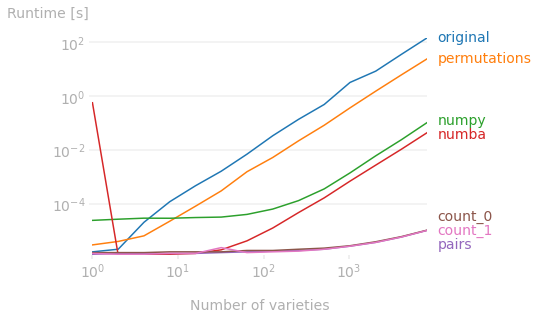

In [9]:
rng = np.random.default_rng(seed = 1)
perfplot.show(
    setup=lambda n: rng.choice([0, 1, 2, -1], n, p = [1/4, 1/4, 1/4, 1/4]),
    kernels=[
        lambda a: score_original(a),
        lambda a: score_perm(a),
        lambda a: score_numpy(a),
        lambda a: score_numba(a),
        lambda a: score_pairs(a),
        lambda a: score_count0(a),
        lambda a: score_count1(a),
    ],
    labels=["original", "permutations", "numpy", "numba", "pairs", "count_0", "count_1"],
    n_range=[2**k for k in range(14)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

* Even distribution of variety scores codes, no invalid

Output()

(1.100000000000001e-06, 188.57147999999998)


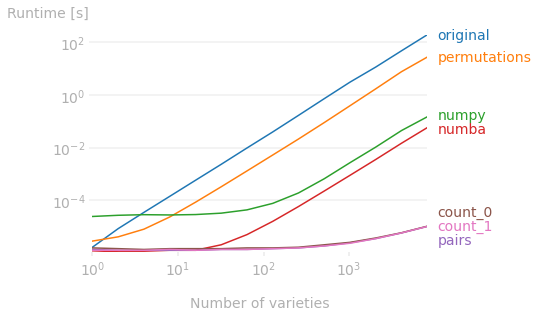

In [10]:
rng = np.random.default_rng(seed = 1)
perfplot.show(
    setup=lambda n: rng.choice([0, 1, 2, -1], n, p = [1/3, 1/3, 1/3, 0]),
    kernels=[
        lambda a: score_original(a),
        lambda a: score_perm(a),
        lambda a: score_numpy(a),
        lambda a: score_numba(a),
        lambda a: score_pairs(a),
        lambda a: score_count0(a),
        lambda a: score_count1(a),
    ],
    labels=["original", "permutations", "numpy", "numba", "pairs", "count_0", "count_1"],
    n_range=[2**k for k in range(14)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

* Uneven distribution of codes

Output()

(1.100000000000001e-06, 143.93081130000004)


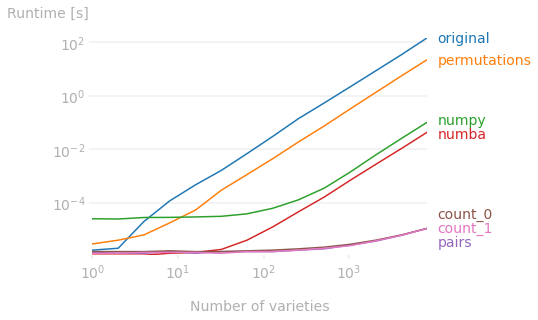

In [11]:
rng = np.random.default_rng(seed = 1)
perfplot.show(
    setup=lambda n: rng.choice([0, 1, 2, -1], n, p = [1/12, 6/12, 2/12, 3/12]),
    kernels=[
        lambda a: score_original(a),
        lambda a: score_perm(a),
        lambda a: score_numpy(a),
        lambda a: score_numba(a),
        lambda a: score_pairs(a),
        lambda a: score_count0(a),
        lambda a: score_count1(a),
    ],
    labels=["original", "permutations", "numpy", "numba", "pairs", "count_0", "count_1"],
    n_range=[2**k for k in range(14)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

* Uneven distribution of codes, no invalid

Output()

(1.100000000000001e-06, 188.42970049999997)


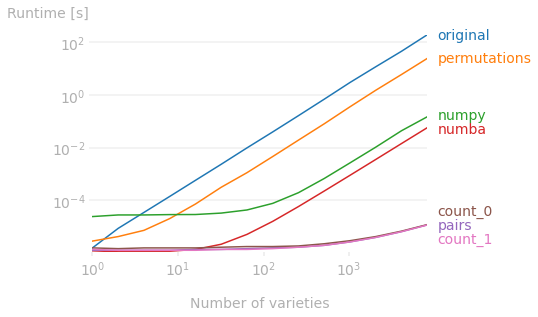

In [12]:
rng = np.random.default_rng(seed = 1)
perfplot.show(
    setup=lambda n: rng.choice([0, 1, 2, -1], n, p = [2/12, 7/12, 3/12, 0]),
    kernels=[
        lambda a: score_original(a),
        lambda a: score_perm(a),
        lambda a: score_numpy(a),
        lambda a: score_numba(a),
        lambda a: score_pairs(a),
        lambda a: score_count0(a),
        lambda a: score_count1(a),
    ],
    labels=["original", "permutations", "numpy", "numba", "pairs", "count_0", "count_1"],
    n_range=[2**k for k in range(14)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)